In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load dataset
dataset=pd.read_csv('./diabetes.csv')
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#Show Key Statistics
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
# importing package
import pandas_profiling as pp
from IPython.display import IFrame

# Profile Report
dataset2 = pp.ProfileReport(dataset)
dataset2.to_file('diabetesLDAQDA.html')
display(IFrame('diabetesLDAQDA.html', width=900, height=350))

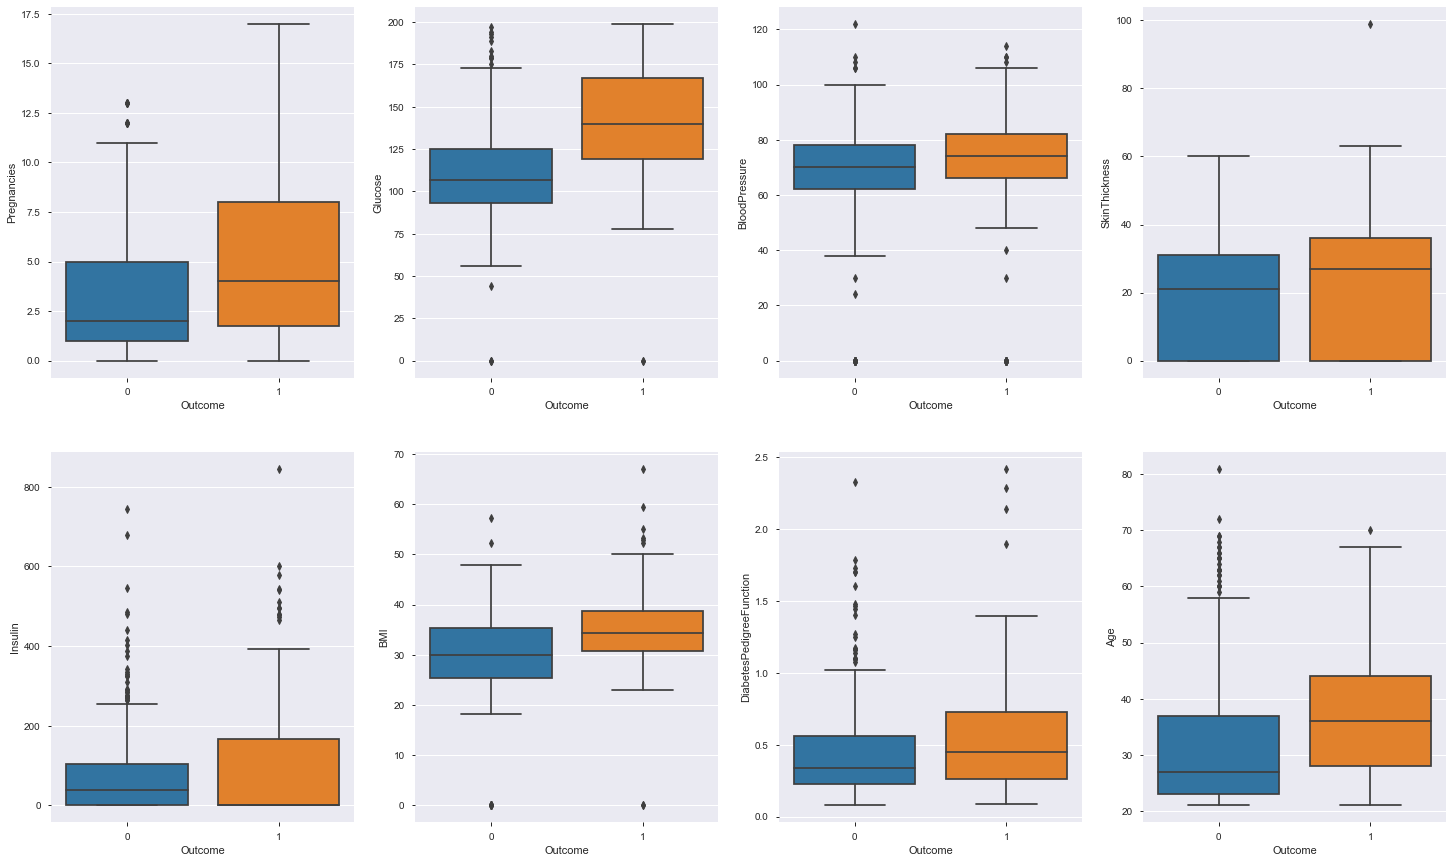

In [5]:
#Boxplot of Features

fig,ax=plt.subplots(nrows=2 ,ncols=4)

sns.boxplot(data=dataset,y='Pregnancies',x='Outcome',ax=ax[0,0])
sns.boxplot(data=dataset,y='Glucose',x='Outcome',ax=ax[0,1])
sns.boxplot(data=dataset,y='BloodPressure',x='Outcome',ax=ax[0,2])
sns.boxplot(data=dataset,y='SkinThickness',x='Outcome',ax=ax[0,3])
sns.boxplot(data=dataset,y='Insulin',x='Outcome',ax=ax[1,0])
sns.boxplot(data=dataset,y='BMI',x='Outcome',ax=ax[1,1])
sns.boxplot(data=dataset,y='DiabetesPedigreeFunction',x='Outcome',ax=ax[1,2])
sns.boxplot(data=dataset,y='Age',x='Outcome',ax=ax[1,3])

fig.set_figwidth(25)
fig.set_figheight(15)

In [7]:
#Create x and y variables
x = dataset.drop('Outcome', axis=1).values
Y = dataset['Outcome'].values

#Create Training Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_sample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Import Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [8]:
#Class Balance - Test Data
print('Train Data - Class Split')
num_zeros = (y_train_smt == 0).sum()
num_ones = (y_train_smt == 1).sum()
print('Class 0 -',  num_zeros)
print('Class 1 -',  num_ones)

Train Data - Class Split
Class 0 - 400
Class 1 - 400


In [9]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_lda = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearDiscriminantAnalysis())])
pipeline.insert(0,pipe_lda)

pipe_qda = Pipeline([('scl', StandardScaler()),
                    ('clf', QuadraticDiscriminantAnalysis())])
pipeline.insert(1,pipe_qda)

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='liblinear',
                                               class_weight='balanced',
                                               random_state=100))])   
pipeline.insert(2,pipe_logreg)
    
    
# Set grid search params 

modelpara =[]

param_gridlda = {'clf__solver':['svd','lsqr','eigen']}
modelpara.insert(0,param_gridlda)

param_gridqda = {}
modelpara.insert(1,param_gridqda)

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}
modelpara.insert(2,param_gridlogreg)

In [10]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.6, 1.0])
    plt.show()

LDA Learning Curve


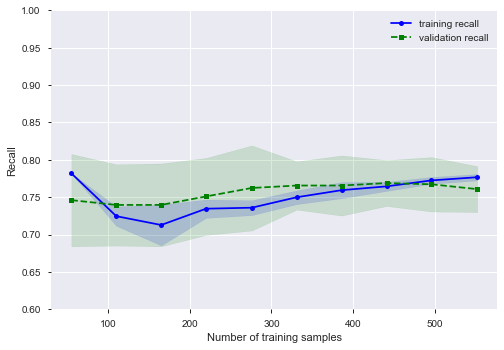


 QDA Learning Curve


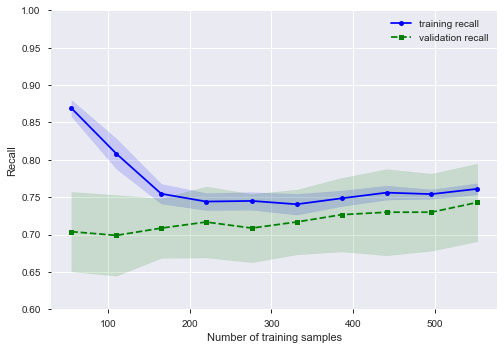


 Logistic Regression Learning Curve


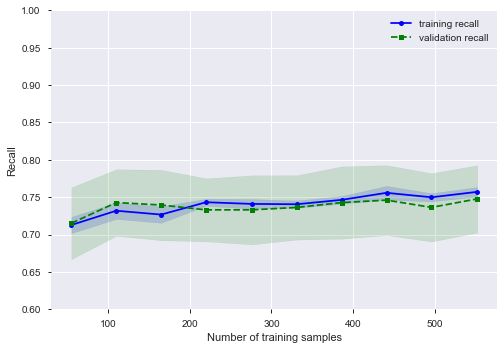

In [11]:
#Plot Learning Curve
print('LDA Learning Curve')
plot_learning_curves(pipe_lda)
print('\n QDA Learning Curve')
plot_learning_curves(pipe_qda)
print('\n Logistic Regression Learning Curve')
plot_learning_curves(pipe_logreg)

Model Evaluation - Recall Score
LDA 0.77 +/- 0.05
QDA 0.74 +/- 0.05
Log Reg 0.76 +/- 0.05




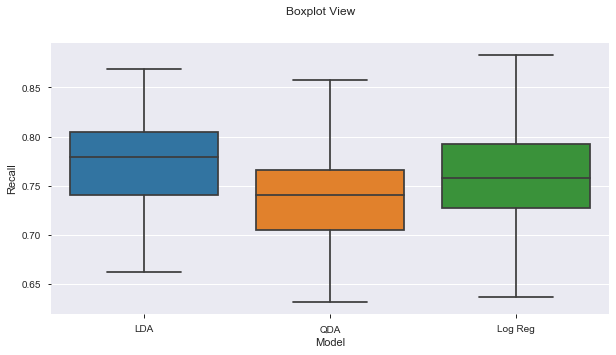

In [12]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LDA',pipe_lda))
models.append(('QDA',pipe_qda))
models.append(('Log Reg',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,Y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n') 

fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [13]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train2, y_train_smt)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, x_2, Y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test2)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

Best Parameters: {'clf__solver': 'svd'}

 [[72 28]
 [13 41]]

              precision    recall  f1-score   support

  Outcome 0       0.85      0.72      0.78       100
  Outcome 1       0.59      0.76      0.67        54

avg / total       0.76      0.73      0.74       154


NestedCV Accuracy(weighted) :0.77 +/-0.02 
NestedCV Precision(weighted) :0.77 +/-0.03 
NestedCV Recall(weighted) :0.77 +/-0.02 


ROC Curve


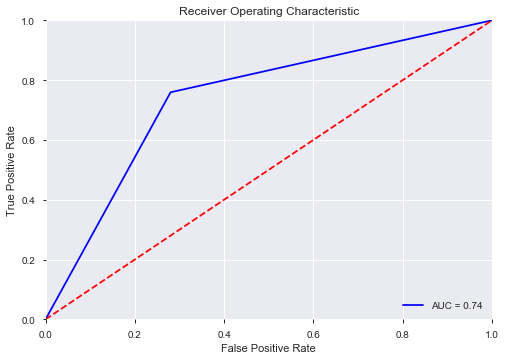


Optimized Model

Model Name: QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001)

Best Parameters: {}

 [[77 23]
 [15 39]]

              precision    recall  f1-score   support

  Outcome 0       0.84      0.77      0.80       100
  Outcome 1       0.63      0.72      0.67        54

avg / total       0.76      0.75      0.76       154


NestedCV Accuracy(weighted) :0.75 +/-0.02 
NestedCV Precision(weighted) :0.74 +/-0.02 
NestedCV Recall(weighted) :0.75 +/-0.02 


ROC Curve


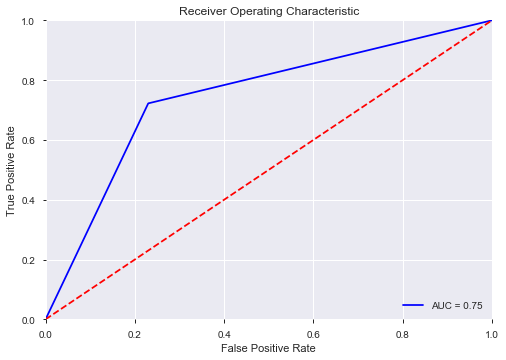


Optimized Model

Model Name: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=100,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l1'}

 [[74 26]
 [12 42]]

              precision    recall  f1-score   support

  Outcome 0       0.86      0.74      0.80       100
  Outcome 1       0.62      0.78      0.69        54

avg / total       0.78      0.75      0.76       154


NestedCV Accuracy(weighted) :0.76 +/-0.04 
NestedCV Precision(weighted) :0.77 +/-0.04 
NestedCV Recall(weighted) :0.76 +/-0.04 


ROC Curve


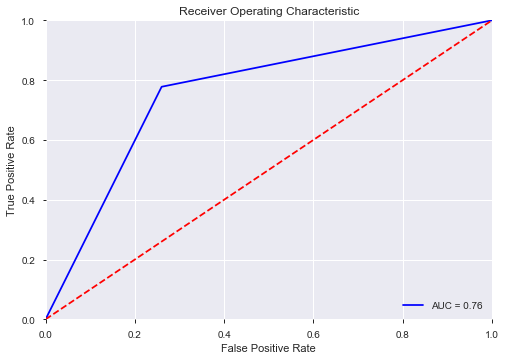

In [14]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

C:\Users\noopa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


LDA

Permutation Importance




Weight,Feature
0.1442 ± 0.0741,Glucose
0.0143 ± 0.0414,DiabetesPedigreeFunction
0.0091 ± 0.0382,Pregnancies
0.0052 ± 0.0252,BMI
-0.0026 ± 0.0064,SkinThickness
-0.0104 ± 0.0335,BloodPressure
-0.0169 ± 0.0303,Insulin
-0.0234 ± 0.0132,Age


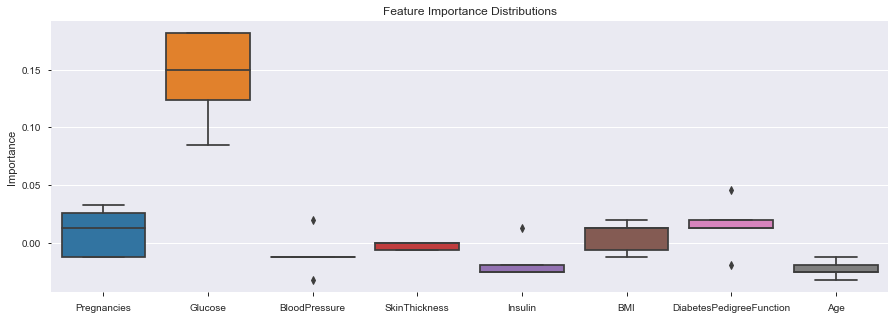

QDA

Permutation Importance




Weight,Feature
0.1390 ± 0.0746,Glucose
0.0429 ± 0.0373,Pregnancies
0.0299 ± 0.0314,DiabetesPedigreeFunction
0.0221 ± 0.0447,Insulin
0.0208 ± 0.0389,BMI
0.0156 ± 0.0194,Age
0.0052 ± 0.0223,SkinThickness
0.0026 ± 0.0194,BloodPressure


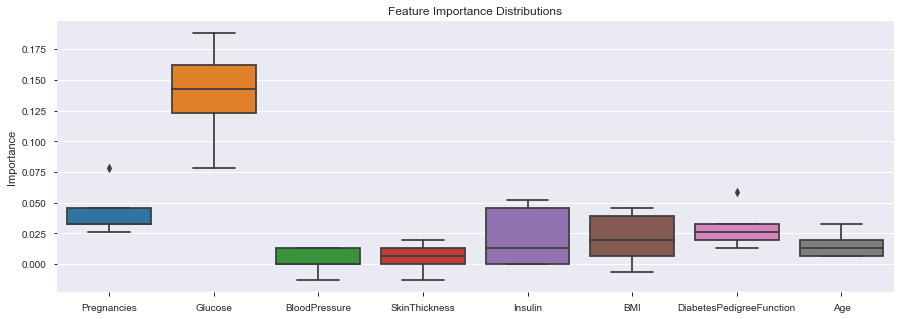

Log Reg

Permutation Importance




Weight,Feature
0.1481 ± 0.0781,Glucose
0.0221 ± 0.0364,Pregnancies
0.0208 ± 0.0502,DiabetesPedigreeFunction
0.0208 ± 0.0362,BMI
-0.0013 ± 0.0252,BloodPressure
-0.0065 ± 0.0082,SkinThickness
-0.0091 ± 0.0424,Insulin
-0.0156 ± 0.0132,Age


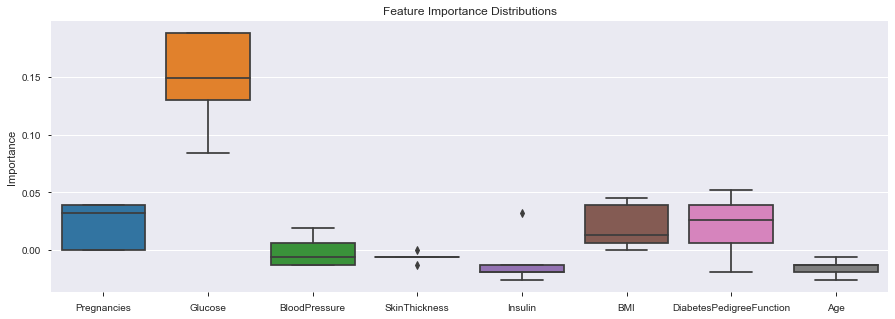

In [15]:
#Next Step - Feature Importance
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

for name, model in models:
    print(name)
    perm=PermutationImportance(model.fit(x_train2,y_train_smt),random_state=100).fit(x_test2,y_test)
    features=dataset.drop('Outcome', axis=1).columns
    print('\nPermutation Importance')
    print('\n')
    df=eli5.show_weights(perm,feature_names=dataset.drop('Outcome', axis=1).columns.tolist())
    display(df)
    df2= pd.DataFrame(data=perm.results_,columns=features)
    fig = plt.figure(figsize=(15,5))
    sns.boxplot(data=df2).set(title='Feature Importance Distributions',
                             ylabel='Importance')
    plt.show()